## Flight Price prediction Project Overview

Created a tool that predicts flight price with 95% accuracy
Data source from Kaggle https://www.kaggle.com/anshigupta01/flight-price-prediction/data
The data source is in excell format: Data Train,
Code and Resources Used
Python Version: 3.8
Packages: pandas, numpy, matplotlib, seaborn, sklearn
	!['Project Overview'](airplane.jpg)

In [1]:
#Import necessary libraries

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix


In [2]:
# Loading excell Data_Train for review.
df_train = pd.read_excel(r"C:\Users\Piotr\Documents\DS projects\resume_projects\Flight_price_prediction\Data_Train.xlsx")
df_train.head()


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
# Show Data Frame size
df_train.shape

(10683, 11)

## Data pre-processing
Data Frame requires some pre-processing.  I will extract more useful information from Data Frame in numeric format. Data require below actions:
<dl>
  <dd>Clean and change type of data that will be usable for models prediction.</dd>
  <dd>Manage missing data</dd>
  <dd>Create numeric columns</dd>
</dl>

In [4]:
# Show sum of missing data in Data Frame 
df_train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Data Frame have 2 Nan values in column Route and Total_Stops.
Im expecting that its one line.
Best option the will be to drop the line.

In [5]:
#Investigate Nan values in Data Frame

df_null = df_train[df_train.isnull().any(axis=1)]
df_null

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [6]:
# Dropping Nan line from Data Frame

df_train.dropna(inplace=True)
df_train.shape


(10682, 11)

In [7]:
# Data type check
df_train.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [8]:
# Create Hours and Minutes columns from Dep Time column and adjusting data type to intergers.
df_train['Dep_Time_H'] = df_train['Dep_Time'].apply(lambda x: int(x.split(':')[0]))
df_train['Dep_Time_M'] = df_train['Dep_Time'].apply(lambda x: int(x.split(':')[1]))

# Create Hours and Minutes columns from Arrival Time column and adjusting data type to intergers.
arrival_time_day = df_train['Arrival_Time'].apply(lambda x: (x.split(' ')[0]))
df_train['Arrival_Time_H'] = arrival_time_day.apply(lambda x: int(x.split(':')[0]))
df_train['Arrival_Time_M'] = arrival_time_day.apply(lambda x: int(x.split(':')[1]))

In [9]:
# Create new columns representing day and month of journey form Date of Journey column

df_train['Date_of_Journey']=pd.to_datetime(df_train['Date_of_Journey'])
                                           
df_train['Journey_Day']= df_train['Date_of_Journey'].dt.day
df_train['Journey_Month']=df_train['Date_of_Journey'].dt.month                                    
df_train.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_Time_H,Dep_Time_M,Arrival_Time_H,Arrival_Time_M,Journey_Day,Journey_Month
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,22,20,1,10,24,3
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,5,50,13,15,5,1
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,25,4,25,6,9


In [10]:
# Adjust duration column to one format "0h 0m"
duration=list(df_train['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' '))==2:
        pass
    else:
        if 'h' in duration[i]: 
             duration[i]=duration[i] + ' 0m' 
        else:
             duration[i]='0h '+ duration[i]

df_train['Duration']=duration


# Create Total duration in minutes from  ajuusted duration colum
duration_h = df_train['Duration'].apply(lambda x: int(x.split(' ')[0][0:-1]))
duration_m = df_train['Duration'].apply(lambda x: int(x.split(' ')[1][0:-1]))
df_train['Total_Duration_in_min'] = duration_h * 60 + duration_m

In [11]:
# Total stops column will change to numerical values
dict={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}
df_train['Total_Stops']=df_train['Total_Stops'].map(dict)
df_train.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_Time_H,Dep_Time_M,Arrival_Time_H,Arrival_Time_M,Journey_Day,Journey_Month,Total_Duration_in_min
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,22,20,1,10,24,3,170
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,5,50,13,15,5,1,445
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h 0m,2,No info,13882,9,25,4,25,6,9,1140


In [12]:
# Spliting Airport codes from Route column. Cost asociated with airports is part of ticket price.

df_train['Route1']=df_train['Route'].str.split('→').str[0]
df_train['Route2']=df_train['Route'].str.split('→').str[1]
df_train['Route3']=df_train['Route'].str.split('→').str[2]
df_train['Route4']=df_train['Route'].str.split('→').str[3]
df_train['Route5']=df_train['Route'].str.split('→').str[4]

# The New Route columns will have NaN values. As most of flightts will be represented by source and destination airport only.
df_train.isnull().sum()

Airline                      0
Date_of_Journey              0
Source                       0
Destination                  0
Route                        0
Dep_Time                     0
Arrival_Time                 0
Duration                     0
Total_Stops                  0
Additional_Info              0
Price                        0
Dep_Time_H                   0
Dep_Time_M                   0
Arrival_Time_H               0
Arrival_Time_M               0
Journey_Day                  0
Journey_Month                0
Total_Duration_in_min        0
Route1                       0
Route2                       0
Route3                    3491
Route4                    9116
Route5                   10636
dtype: int64

In [13]:
# For loop that will replace NaN values to None
for i in ['Route3', 'Route4', 'Route5']:
    df_train[i].fillna('None',inplace=True)
    
# Making sure that Data Dframe do not include NaN values.  
np.where(pd.isnull(df_train).sum())

(array([], dtype=int64),)

In [14]:
# Droping all object columns that I parsed for useful values for models.
df_train.drop(['Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Duration', 'Route'], axis=1, inplace=True)
df_train.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Dep_Time_H,Dep_Time_M,Arrival_Time_H,Arrival_Time_M,Journey_Day,Journey_Month,Total_Duration_in_min,Route1,Route2,Route3,Route4,Route5
0,IndiGo,Banglore,New Delhi,0,No info,3897,22,20,1,10,24,3,170,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,2,No info,7662,5,50,13,15,5,1,445,CCU,IXR,BBI,BLR,None
2,Jet Airways,Delhi,Cochin,2,No info,13882,9,25,4,25,6,9,1140,DEL,LKO,BOM,COK,None
3,IndiGo,Kolkata,Banglore,1,No info,6218,18,5,23,30,5,12,325,CCU,NAG,BLR,None,None
4,IndiGo,Banglore,New Delhi,1,No info,13302,16,50,21,35,3,1,285,BLR,NAG,DEL,None,None


In [15]:
# Show data frame column type
df_train.dtypes

Airline                  object
Source                   object
Destination              object
Total_Stops               int64
Additional_Info          object
Price                     int64
Dep_Time_H                int64
Dep_Time_M                int64
Arrival_Time_H            int64
Arrival_Time_M            int64
Journey_Day               int64
Journey_Month             int64
Total_Duration_in_min     int64
Route1                   object
Route2                   object
Route3                   object
Route4                   object
Route5                   object
dtype: object

## Exploratory Data Analysis

Explore numeric data for more information. Will analyze and investigate numeric data, summarize their main characteristics, by using visualization methods
<dl>

  <dd>Review of basic statistic</dd>
  <dd>Plot Prices, Total Duration in minutes, Source</dd>
  <dd>Investigate and manage outliers</dd>
  <dd>Create the correlation matrix for numerical values</dd>
</dl>


In [16]:
# Review of basisc statistic for numerical columns.
df_train.describe().T


,count,mean,std,min,25%,50%,75%,max
Total_Stops,10682.0,0.824190,0.675229,0.0,0.0,1.0,1.0,4.0
Price,10682.0,9087.214567,4611.548810,1759.0,5277.0,8372.0,12373.0,79512.0
Dep_Time_H,10682.0,12.491013,5.748820,0.0,8.0,11.0,18.0,23.0
Dep_Time_M,10682.0,24.409287,18.767801,0.0,5.0,25.0,40.0,55.0
Arrival_Time_H,10682.0,13.349186,6.859317,0.0,8.0,14.0,19.0,23.0
Arrival_Time_M,10682.0,24.690601,16.506808,0.0,10.0,25.0,35.0,55.0
Journey_Day,10682.0,12.682925,8.803800,3.0,5.0,6.0,21.0,27.0
Journey_Month,10682.0,5.534731,2.987626,1.0,3.0,5.0,6.0,12.0
Total_Duration_in_min,10682.0,643.020502,507.830133,5.0,170.0,520.0,930.0,2860.0


The prices column have quite a wide range of values from min 1759 to max 79512. This might be caused by some outliers. Also, the Total Duration Time in minutes has quite a large range between 170 to 2860 minutes. Let's investigate potential outliers further.

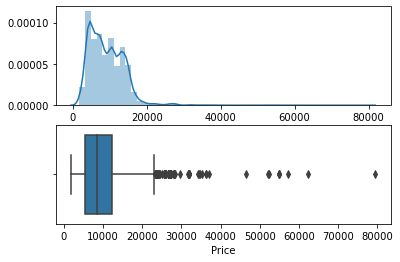

In [17]:
# Function that will plot subplot distribution and box plot for Price
def plot(data, col):
    fig,(ax1,ax2)=plt.subplots(2, 1)
    sns.distplot(data[col],ax=ax1)
    sns.boxplot(data[col],ax=ax2)
    
# Call funcition on Data Frame column price
plot(df_train, 'Price')

In [18]:
# Investigate price outliers above 40000 rupias.
outliers_price = df_train[df_train['Price'] > 40000]
print('The number of outliers is:',outliers_price['Price'].count())
outliers_price.pivot_table(values='Price', index='Airline')


The number of outliers is: 9


,Price
Airline,
Jet Airways,54826.000000
Jet Airways Business,58358.666667


Most Airlines average prices are close to the total average of 9k for all airlines. The Jet Airways Business seems to include business class tickets as its median is 58k. The Data Frame is not representing business ticket price as it's only 9 lines. Statistical models will not be able to predict this class ticket correctly(small sample). I'm going to drop outliers price lines.

In [19]:
# Drop price outliers 
new_df=df_train[~df_train.isin(outliers_price)].dropna(how = 'all')
df_train = new_df
df_train.shape

(10673, 18)

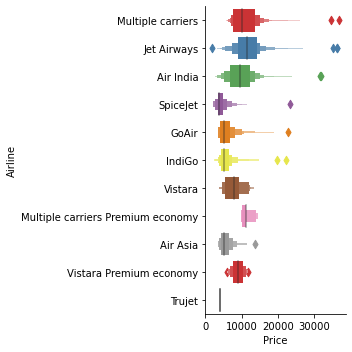

In [20]:
# Plot Airlines price after dropping outliers.
sns.catplot(data=df_train.sort_values('Price',ascending=False), x='Price', y='Airline', kind='boxen',  palette="Set1")

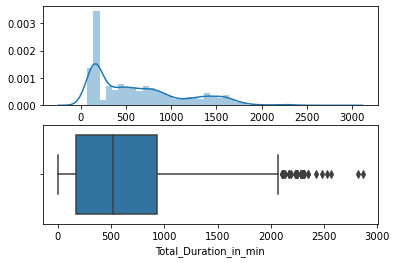

In [21]:
# Plot distribution and boxplot for Total duration in minutes.
plot(df_train, 'Total_Duration_in_min')

In [22]:
# Investigate Total duration in minutes outliers
outliers_time = df_train[df_train['Total_Duration_in_min'] > 2000]
print('The number of outliers is:',outliers_time['Total_Duration_in_min'].count())
outliers_time.pivot_table(values=['Total_Duration_in_min', 'Total_Stops', 'Price'], index=['Airline', 'Source', 'Destination'])


The number of outliers is: 82


Price  Total_Duration_in_min  \
Airline     Source   Destination                                        
Air India   Banglore New Delhi    14139.600000            2220.000000   
            Delhi    Cochin       10673.324324            2257.567568   
            Kolkata  Banglore     12887.666667            2180.833333   
            Mumbai   Hyderabad    13011.500000            2245.000000   
Jet Airways Delhi    Cochin       14697.000000            2280.555556   

                                  Total_Stops  
Airline     Source   Destination               
Air India   Banglore New Delhi       2.100000  
            Delhi    Cochin          2.351351  
            Kolkata  Banglore        2.333333  
            Mumbai   Hyderabad       2.000000  
Jet Airways Delhi    Cochin          2.000000

In [23]:
# Arithmetic mean for price 
print('The average total price:   ', round(df_train['Price'].mean(), 2))
print('The average outliers price:', round(outliers_time['Price'].mean(),2))


The average total price:    9046.66
The average outliers price: 12639.96


We have 82 flights where the duration time is above 2000 minutes - 33 hours. All those flights have 2 or more stopovers. The average time outliers price is a bit higher (12.6k) than to mean price(9k) for all flights. I'm going to keep those data unchanged as more stopovers affect the price by 38%.

<Figure size 1080x1080 with 0 Axes>

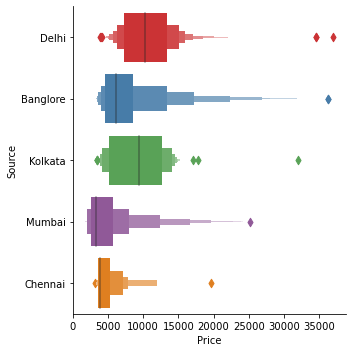

In [24]:
# Plot Departure airport price

plt.figure(figsize=(15,15))

sns.catplot(x='Price', y='Source',data=df_train.sort_values('Price',ascending=False), kind='boxen', palette="Set1")


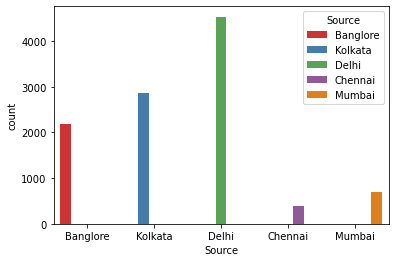

Delhi       4534
Kolkata     2871
Banglore    2190
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [64]:
# Plot the count of Source 
sns.countplot(x=df_train['Source'], hue=df_train['Source'], palette="Set1")
plt.show()
df_train['Source'].value_counts()

According to Source plots for Delhi and Kolkata average price is higher than for other Airports. Those two ariports represent 7405 lines (69%)of data.

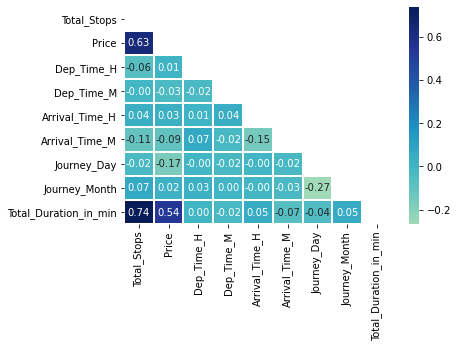

In [26]:
# Create the correlation matrix for numerical values in DF.
corr = df_train.corr()

# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=bool)) # - mask reduce duplication on chart its more readable

# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, center=0, linewidths=1, cmap="YlGnBu", annot=True, fmt=".2f")
plt.show()

Correlation Matrix is giving a good infication that Total Duration in minutes(51%), Jurney Day(17%), Arrival time(9%) are good price indicators. Those 3 varlables correlate with price in 77%.
     

### Handling categorical data

As sklearn models require all data to be numeric or vector values. The categorical data need to be transformed.
<dl>
  <dd>Nominal data are informative that needs to be changed to dummy variables.</dd>
  <dd>Ordinal Data are for categories with an inherent order were retaining the order is important. </dd>
</dl>

<dl>
  <dd>One hot encoding metod for nominal columns:</dd>
  <dd>Airline, Source, Destination, Additional_Info </dd>
  <dd> </dd>
  <dd>Label Encoding etod for ordinal columns:</dd> 
  <dd>Route1, Route2, Route3, Route4, Route5:</dd>
  
</dl>

In [27]:
# Spliting data train for numerical and categorical to handle categorical data.
numeric_data = df_train.select_dtypes(include=[np.number])
categorical_data = df_train.select_dtypes(exclude=[np.number])

# Show categorical data.
categorical_data.head(3)

,Airline,Source,Destination,Additional_Info,Route1,Route2,Route3,Route4,Route5
0,IndiGo,Banglore,New Delhi,No info,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,No info,CCU,IXR,BBI,BLR,None
2,Jet Airways,Delhi,Cochin,No info,DEL,LKO,BOM,COK,None


In [28]:
# Onehot encoding for variables without quantitative value.
labels = ['Route1', 'Route2', 'Route3', 'Route4', 'Route5']
ohe_categorical = categorical_data.drop(labels=labels, axis=1)
ohe_categorical.head(3)

,Airline,Source,Destination,Additional_Info
0,IndiGo,Banglore,New Delhi,No info
1,Air India,Kolkata,Banglore,No info
2,Jet Airways,Delhi,Cochin,No info


In [29]:
# Create dummies variables for nonquantitive values
categorical_dumm =pd.get_dummies(ohe_categorical, drop_first=True)
print('Number of columns for dummies variables:', categorical_dumm.shape[1])
categorical_dumm.columns

Number of columns for dummies variables: 28


Index(['Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi',
       'Additional_Info_1 Short layover', 'Additional_Info_2 Long layover',
       'Additional_Info_Business class', 'Additional_Info_Change airports',
       'Additional_Info_In-flight meal not included',
       'Additional_Info_No Info',
       'Additional_Info_No check-in baggage included',
       'Additional_Info_No info', 'Additional_Info_Red-eye flight'],
      dtype='object')

In [30]:
# Create data frame for Routes variables.
le_categorical = categorical_data.drop(ohe_categorical, axis=1)
le_categorical.head(3)

,Route1,Route2,Route3,Route4,Route5
0,BLR,DEL,None,None,None
1,CCU,IXR,BBI,BLR,None
2,DEL,LKO,BOM,COK,None


In [31]:
# Convert Routes variables by using Label Encoder

# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Create a boolean mask for categorical variables
categorical_mask = (le_categorical.dtypes == 'object')

# Get list of route variables column names
route_columns = le_categorical.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(le_categorical[route_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
le_categorical[route_columns] = le_categorical[route_columns].apply(lambda x: le.fit_transform(x))

# Print the head of the LabelEncoded categorical columns
print(le_categorical[route_columns].head())

  Route1 Route2 Route3 Route4 Route5
0   BLR     DEL   None   None   None
1   CCU    IXR    BBI     BLR   None
2   DEL    LKO    BOM     COK   None
3   CCU    NAG     BLR   None   None
4   BLR    NAG     DEL   None   None
   Route1  Route2  Route3  Route4  Route5
0       0      13      29      13       5
1       2      25       1       3       5
2       3      32       4       5       5
3       2      34       3      13       5
4       0      34       8      13       5


In [32]:
# Join categorical and numerical varables in one Data frame. 

final_df = pd.concat([numeric_data, categorical_dumm, le_categorical[route_columns]],axis=1)

In [33]:
# List of final columns.
print('Number of columns in final Data frame', final_df.shape[1])
final_df.columns

Number of columns in final Data frame 42


Index(['Total_Stops', 'Price', 'Dep_Time_H', 'Dep_Time_M', 'Arrival_Time_H',
       'Arrival_Time_M', 'Journey_Day', 'Journey_Month',
       'Total_Duration_in_min', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi',
       'Additional_Info_1 Short layover', 'Additional_Info_2 Long layover',
       'Additional_Info_Business class', 'Additional_Info_Change airports',
       'Additional_Info_In-flight meal not included',
       'Additional_Info_No Info',
       'Additional_Info_No check-in baggage included',
       'Additional_Info_No info', 'Additional_Info_Red-eye flight',

In [34]:
# Separate Price targed value from variable
X=final_df.drop('Price',axis=1)
y=final_df['Price']

## Feature Selection
Preprocessing and Features Engineering delivered 42 columns. The orginal data have only 11. To avid probleem with high demontionalyty I will use Sklearn features extraction method Mutual_info_classif 
This method basically utilize the mutual information. It calculates mutual information value for each of independent variables with respect to dependent variable, and selects the ones which has most information gain. In other words, it basically measures the dependency of features with the target value. The higher score means more dependent variables.

In [35]:
# Import method from sklearn
from sklearn.feature_selection import mutual_info_classif

In [36]:
# Apply to independent variables x and dependent variable y.
mutual_info_classif(X,y)

array([2.12601329e+00, 1.42728549e+00, 1.19212176e+00, 1.87250907e+00,
       1.52126831e+00, 1.07195512e+00, 8.62216722e-01, 2.37995598e+00,
       7.46643951e-01, 1.00964908e-01, 6.72428102e-01, 9.09278922e-01,
       5.63184960e-01, 2.07848440e-02, 3.16352658e-01, 0.00000000e+00,
       2.20749702e-01, 7.40206051e-03, 1.68618782e-01, 1.54966340e+00,
       8.83901062e-01, 2.89696629e-01, 1.57096143e+00, 4.04162250e-01,
       2.82655816e-01, 1.76158525e-01, 3.60452279e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.25926924e-02, 6.18949240e-01,
       0.00000000e+00, 1.50392055e-01, 2.02233060e+00, 1.36949845e-03,
       2.07289056e+00, 2.77364370e+00, 2.29418589e+00, 1.51681301e+00,
       7.96305743e-01])

In [37]:
# Assign ariable name to mutual info classifier array
variable_imp = pd.DataFrame(mutual_info_classif(X, y), index=X.columns, columns=['importance'])

# Show sorted mutual info classifier values in sorted by descending order
variable_imp.sort_values(by='importance', ascending=False)


,importance
Route2,2.736324
Total_Duration_in_min,2.378163
Route3,2.307749
Total_Stops,2.103406
Route1,2.035982
Additional_Info_No info,1.982108
Arrival_Time_H,1.874335
Source_Delhi,1.541531
Destination_Cochin,1.516429
Arrival_Time_M,1.511719


In [38]:
# Drop columns where mutual info classifier is equal to 0
outlist = variable_imp[variable_imp['importance'] == 0]
outlist_col = (outlist.index).tolist()
X.drop(columns = outlist_col, axis=1, inplace=True)
X.shape

(10673, 39)

## Model Building
<dl>
  <dd>First, I split the data into train and tests sets with a test size of 20%.</dd>
  <dd>As price prediction is regression problem I will try thebelow model from sklearn:</dd>
  <dd>This is one definition of the second term. </dd>
  <dd>Linear Model,</dd>
  <dd>Logistic Regression,</dd>
  <dd>KNeighbors Regressor,</dd>
  <dd>Decision TreeRegressor,</dd>
  <dd>Gradient Boosting Regressor, </dd>
  <dd>Random Forest Regressor,</dd>
  <dt>The best model will be chosen and I will tune hyperparameters to reach the best model predictions.</dt>
</dl>

In [39]:
# Spiliting the dataset for train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=21)

In [40]:
# Import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Define function that run models, print results and display prediction error

def predict(ml_model):
    """Function will run models, print results and display prediction"""
    print('Model is: {}'.format(ml_model))
    model= ml_model.fit(X_train, y_train)
    print("Training score: {}".format(model.score(X_train, y_train)))
    predictions = model.predict(X_test)
    print("Predictions are: {}".format(predictions))
    print('\n')
    r2score = r2_score(y_test, predictions) 
    print("Test score is: {}".format(r2score))
          
    print('MAE:  {}'.format(mean_absolute_error(y_test, predictions)))
    print('MSE:  {}'.format(mean_squared_error(y_test, predictions)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, predictions))))
    
    # Distribution plot between actual value and predicted value
    sns.distplot(y_test-predictions)      
          

In [41]:
# Import models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

Model is: Ridge(alpha=0.5)
Training score: 0.6895138053663284
Predictions are: [14274.87601519 13133.86784625  8248.98810029 ...  9945.5192584
 11735.62972132 11453.5737809 ]


Test score is: 0.6821910945777735
MAE:  1727.9923263276523
MSE:  6609619.229662573
RMSE: 2570.9179741218063


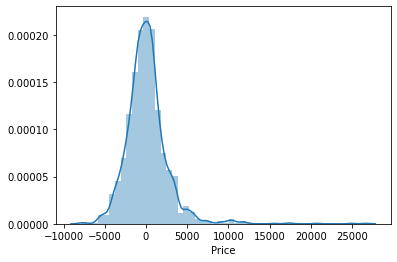

In [42]:
# Run simple Linear regresion model
predict(linear_model.Ridge(alpha=.5))

Model is: LogisticRegression()


C:\Users\Piotr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training score: 0.07027406886858749
Predictions are: [10262. 10844.  7229. ... 10262. 10262. 14151.]


Test score is: 0.30550362036556566
MAE:  2745.2046838407496
MSE:  14443763.36674473
RMSE: 3800.4951475754747


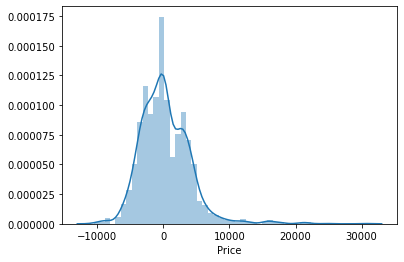

In [43]:
# Run Logistic regresion model
predict(LogisticRegression())

Model is: KNeighborsRegressor()
Training score: 0.7483314733138755
Predictions are: [11051.2 11865.4  4987.  ... 11479.4  9114.2 13185.2]


Test score is: 0.6218461435277831
MAE:  1720.8299765807963
MSE:  7864641.169161593
RMSE: 2804.3967567306863


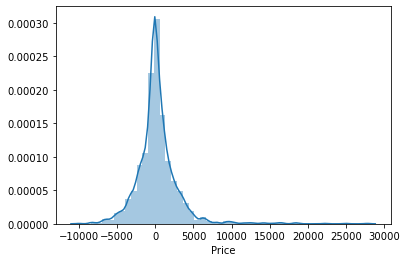

In [44]:
# Run KNR model
predict(KNeighborsRegressor())

Model is: DecisionTreeRegressor()
Training score: 0.9954269319338729
Predictions are: [13941. 10624.  8016. ...  8529.  7198. 14634.]


Test score is: 0.8816097467248346
MAE:  636.4048399687744
MSE:  2462217.015638824
RMSE: 1569.1453137421097


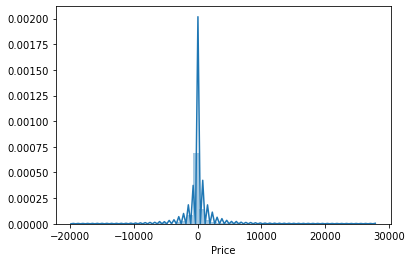

In [45]:
# Run Decision Tree Regressor model
predict(DecisionTreeRegressor())

Model is: GradientBoostingRegressor()
Training score: 0.854645189405383
Predictions are: [13768.36789738 13341.78529027  7755.13321411 ...  9943.74392368
 10505.03398134 12846.41780938]


Test score is: 0.8446900058011856
MAE:  1167.4238085782229
MSE:  3230053.9937716722
RMSE: 1797.2350969674703


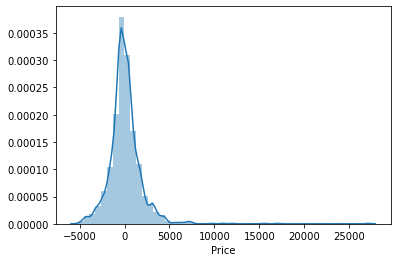

In [46]:
# Run Gradient Boosting Regressor model
predict(GradientBoostingRegressor())

Model is: RandomForestRegressor()
Training score: 0.9854179677626809
Predictions are: [14034.54       12024.06        7992.39       ...  8591.67
  7431.19333333 13753.65666667]


Test score is: 0.91623036445876
MAE:  595.3595623080927
MSE:  1742195.9689883566
RMSE: 1319.9227132633018


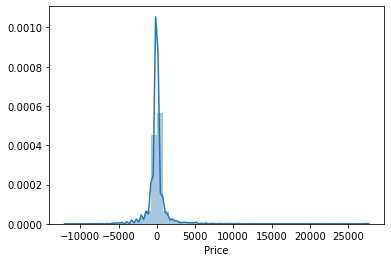

In [47]:
# Run Random Forest Regressor model
predict(RandomForestRegressor())

## Best Model & Hyperparameter Tuning

<dl>
  <dd>The best results delivered by Random Forest Regressor were 98% for the training sample and 91% for test data. This is amazing resutls with simple model before hyperparameters toning</dd>
  <dd>Second, the best model Radient Boosting Regressor delivered 85% for the training sample and 84% for test data. </dd>
</dl>


In [48]:
# Import Randomized SearchCV
from sklearn.model_selection import RandomizedSearchCV

In [49]:
# Define the dictionary for hiperparametres
random_grid = {
    'n_estimators' : [100, 120, 150, 180, 200],
    'max_features':['auto','sqrt'],
    'max_depth':[10, 15, 20],
    'min_samples_leaf': [2, 10, 30]}

In [50]:
# Instantiate Random Forest Regressor
rf=RandomForestRegressor()
rf_random=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,cv=3,verbose=2,n_jobs=-1,)

rf_random.fit(X_train,y_train)

# Show best parameters
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.0s finished


{'n_estimators': 200,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 20}

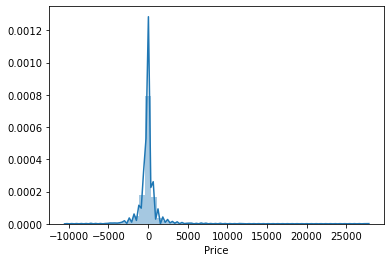

In [51]:
# Predicting test values
prediction = rf_random.predict(X_test)

# Distribution plot between actual value and predicted value
sns.distplot(y_test-prediction) 

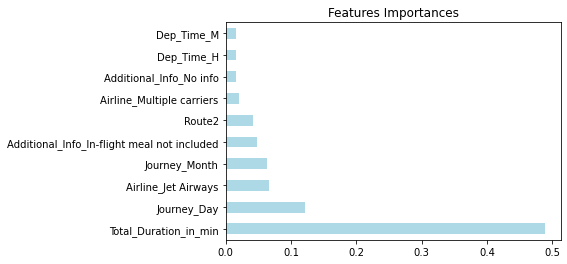

In [52]:
# Create a pd.Series of features for top 10 importances varables for best model.
importances = pd.Series(data=rf_random.best_estimator_.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values(ascending=False).head(10)

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importances')
plt.show()
 

As expected Total Duration in minutes is the most important for price value (48%). Day and Month play also important role for price prediction( 18%). 

In [53]:
# Import Joblib Module from Scikit Learn
import joblib

# Save Best Model to file in the current working directory
joblib_file = "joblib_Best_Model.pkl"  
joblib.dump(rf_random, joblib_file)